<a href="https://colab.research.google.com/github/the77hnx/works-in-the-univ/blob/main/quantisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akrambelha","key":"3fa0e6738defaf8b34de873ff10cc191"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the dataset from Kaggle
!kaggle datasets download -d ipythonx/mvtec-ad --unzip -p /content

Dataset URL: https://www.kaggle.com/datasets/ipythonx/mvtec-ad
License(s): copyright-authors
100% 4.90G/4.91G [01:06<00:00, 125MB/s]
100% 4.91G/4.91G [01:06<00:00, 79.3MB/s]


In [4]:
import os
import cv2
import numpy as np
import albumentations as A
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for split_type in ['train', 'test']:
        split_folder = os.path.join(folder, split_type)
        if os.path.isdir(split_folder):
            if split_type == 'train':
                category_folder = os.path.join(split_folder, 'good')
                if os.path.isdir(category_folder):
                    for filename in os.listdir(category_folder):
                        img_path = os.path.join(category_folder, filename)
                        img = cv2.imread(img_path)
                        if img is not None:
                            images.append(img)
                            labels.append('good')
            else:
                for category in os.listdir(split_folder):
                    category_folder = os.path.join(split_folder, category)
                    if os.path.isdir(category_folder):
                        for filename in os.listdir(category_folder):
                            img_path = os.path.join(category_folder, filename)
                            img = cv2.imread(img_path)
                            if img is not None:
                                images.append(img)
                                labels.append(category)
    return images, labels

# Load images
dataset_folder = '/content/carpet'
images, labels = load_images_from_folder(dataset_folder)

In [6]:
def preprocess_images(images, target_size=(224, 224)):
    processed_images = []
    for img in images:
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0  # Normalize to [0, 1]
        processed_images.append(img)
    return np.array(processed_images)

# Preprocess images
processed_images = preprocess_images(images)

In [7]:
processed_images.shape

(397, 224, 224, 3)

In [8]:
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=40, p=0.7),
        A.Blur(blur_limit=3, p=0.5),
    ])
    for img, label in zip(images, labels):
        augmented = transform(image=img)
        augmented_images.append(augmented['image'])
        augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

# Augment images
augmented_images, augmented_labels = augment_images(processed_images, labels)

In [9]:
augmented_images.shape

(397, 224, 224, 3)

In [10]:
augmented_labels.shape

(397,)

In [11]:
def optimize_resolution(images, target_size=(128, 128)):
    optimized_images = []
    for img in images:
        img = cv2.resize(img, target_size)
        optimized_images.append(img)
    return np.array(optimized_images)

# Optimize resolution
optimized_images = optimize_resolution(augmented_images)

In [12]:
optimized_images.shape

(397, 128, 128, 3)

In [13]:
def balance_dataset(images, labels):
    X = np.array(images)
    y = np.array(labels)
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X.reshape(X.shape[0], -1), y)
    X_resampled = X_resampled.reshape(-1, X.shape[1], X.shape[2], X.shape[3])
    return X_resampled, y_resampled

# Balance dataset
balanced_images, balanced_labels = balance_dataset(optimized_images, augmented_labels)

In [14]:
balanced_images.shape

(1848, 128, 128, 3)

In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

In [16]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

In [17]:
from google.colab import drive
from tensorflow.keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')

# Load models
mobilenet_path = '/content/drive/MyDrive/MobileNet_model.h5'
efficientnet_path = '/content/drive/MyDrive/EfficientNetB0_model.h5'
resnet_path = '/content/drive/MyDrive/ResNet50_model.h5'

mobilenet_model = load_model(mobilenet_path)
efficientnet_model = load_model(efficientnet_path)
resnet_model = load_model(resnet_path)

print("Models loaded successfully.")


Mounted at /content/drive


Models loaded successfully.


In [18]:
import tensorflow as tf

def quantize_model(model):
    # Convert to a TensorFlow Lite model with quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    return tflite_model

# Quantize models
mobilenet_quantized = quantize_model(mobilenet_model)
efficientnet_quantized = quantize_model(efficientnet_model)
resnet_quantized = quantize_model(resnet_model)

# Save quantized models to files
with open('/content/drive/MyDrive/MobileNet_quantized.tflite', 'wb') as f:
    f.write(mobilenet_quantized)

with open('/content/drive/MyDrive/EfficientNetB0_quantized.tflite', 'wb') as f:
    f.write(efficientnet_quantized)

with open('/content/drive/MyDrive/ResNet50_quantized.tflite', 'wb') as f:
    f.write(resnet_quantized)

print("Quantized models saved to Google Drive.")


Saved artifact at '/tmp/tmpqntw7ak9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136156567082912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567180160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567185264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567183152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567189136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567189664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567308064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567309120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567178928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567307888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136156567312816

In [19]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # Get the validation accuracy from logs
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nStopping training as val_accuracy reached {val_accuracy:.2f}, which is greater than or equal to {self.target_accuracy}.")
            self.model.stop_training = True

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define student models for ResNet, EfficientNet, and MobileNet
# 1. Define ResNet student model with Dropout and freeze base model
def create_resnet_student_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)



    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Adding dropout layer
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=x, name="resnet_student_model")


# 2. Define EfficientNet student model with Dropout and freeze base model
def create_efficientnet_student_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freeze the layers of the base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Adding dropout layer
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=x, name="efficientnet_student_model")


# 3. Define MobileNet student model with Dropout and freeze base model
def create_mobilenet_student_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=x, name="mobilenet_student_model")

# 2. Compile the student models
input_shape = (128, 128, 3)  # Adjust input shape if needed
num_classes = 6  # Example for 10 classes (adjust as per your dataset)

# Create individual student models
resnet_student_model = create_resnet_student_model(input_shape, num_classes)
efficientnet_student_model = create_efficientnet_student_model(input_shape, num_classes)
mobilenet_student_model = create_mobilenet_student_model(input_shape, num_classes)

# 3. Compile the models
resnet_student_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
efficientnet_student_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_student_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Define the Distillation Loss
def distillation_loss(y_true, y_pred_student, y_pred_teacher, temperature=3.0, alpha=0.5):
    """Custom loss function for knowledge distillation."""
    # Soft loss (teacher-student divergence)
    soft_loss = tf.keras.losses.KLDivergence()(
        tf.nn.softmax(y_pred_teacher / temperature, axis=1),
        tf.nn.softmax(y_pred_student / temperature, axis=1)
    )
    # Hard loss (true labels)
    hard_loss = CategoricalCrossentropy()(y_true, y_pred_student)
    return alpha * hard_loss + (1 - alpha) * soft_loss

# 5. Custom training loop for Knowledge Distillation
class DistillationTrainer(tf.keras.callbacks.Callback):
    def __init__(self, teacher_model, student_model, temperature=3.0, alpha=0.5):
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.temperature = temperature
        self.alpha = alpha

    def compile(self, optimizer, metrics):
        self.optimizer = optimizer
        self.metrics = metrics

    def train_step(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            y_pred_student = self.student_model(x_batch, training=True)
            y_pred_teacher = self.teacher_model(x_batch, training=False)
            loss = distillation_loss(
                y_true=y_batch,
                y_pred_student=y_pred_student,
                y_pred_teacher=y_pred_teacher,
                temperature=self.temperature,
                alpha=self.alpha
            )
        gradients = tape.gradient(loss, self.student_model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student_model.trainable_variables))
        return {metric.name: metric(y_batch, y_pred_student) for metric in self.metrics}

# 6. Modify callback to stop training when val_accuracy reaches 0.98
# Target validation accuracy
target_accuracy = 0.98

# Create the custom callback
stop_training_callback = StopTrainingAtAccuracy(target_accuracy)

early_stopping = EarlyStopping(monitor='accuracy', patience=50, mode='max')  # Monitor val_accuracy
stop_training_callback = StopTrainingAtAccuracy(target_accuracy=0.96)  # Stop when val_accuracy >= 0.96

# 7. Train Student Model with each Teacher Model
def train_student_with_teacher(teacher_model, student_model, X_train, y_train_categorical, X_test, y_test_categorical, epochs=150):
    distillation_trainer = DistillationTrainer(teacher_model, student_model, temperature=3.0, alpha=0.7)
    distillation_trainer.compile(optimizer=Adam(learning_rate=0.001), metrics=['val_accuracy'])

    # Fit the model using the distillation trainer
    history = student_model.fit(
        X_train,
        y_train_categorical,
        validation_data=(X_test, y_test_categorical),
        epochs=epochs,
        callbacks=[early_stopping, stop_training_callback],
        batch_size=16  # Reduced batch size
    )
    return history

In [21]:
# تدريب نموذج MobileNet
history_mobilenet = train_student_with_teacher(
    teacher_model=mobilenet_model,  # استبدال هذا مع نموذج المعلم
    student_model=mobilenet_student_model,
    X_train=X_train, y_train_categorical=y_train_categorical,
    X_test=X_test, y_test_categorical=y_test_categorical,
    epochs=250
)

Epoch 1/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.3897 - loss: 1.5843 - val_accuracy: 0.6162 - val_loss: 0.9922
Epoch 2/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6880 - loss: 0.9176 - val_accuracy: 0.7568 - val_loss: 0.7497
Epoch 3/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7940 - loss: 0.6545 - val_accuracy: 0.7730 - val_loss: 0.5312
Epoch 4/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8882 - loss: 0.4480 - val_accuracy: 0.7946 - val_loss: 0.5862
Epoch 5/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8855 - loss: 0.3798 - val_accuracy: 0.8162 - val_loss: 0.4340
Epoch 6/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8990 - loss: 0.3253 - val_accuracy: 0.9189 - val_loss: 0.3083
Epoch 7/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9305 - loss: 0.2462 - val_accuracy: 0.9351 - val_loss: 0.2249
Epoch 8/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9610 - loss: 0.1821 - val_accuracy: 

In [22]:
# تدريب نموذج EfficientNet
history_efficientnet = train_student_with_teacher(
    teacher_model=efficientnet_model,  # استبدال هذا مع نموذج المعلم
    student_model=efficientnet_student_model,
    X_train=X_train, y_train_categorical=y_train_categorical,
    X_test=X_test, y_test_categorical=y_test_categorical,
    epochs=250
)

Epoch 1/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 139s 630ms/step - accuracy: 0.6480 - loss: 0.9251 - val_accuracy: 0.1838 - val_loss: 45.5383
Epoch 2/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.9252 - loss: 0.2365 - val_accuracy: 0.2243 - val_loss: 14.5400
Epoch 3/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9291 - loss: 0.3192 - val_accuracy: 0.1486 - val_loss: 38.4505
Epoch 4/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9672 - loss: 0.1145 - val_accuracy: 0.2189 - val_loss: 11.9287
Epoch 5/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9809 - loss: 0.0649 - val_accuracy: 0.2135 - val_loss: 28.6501
Epoch 6/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9860 - loss: 0.0432 - val_accuracy: 0.1865 - val_loss: 73.7629
Epoch 7/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9556 - loss: 0.2022 - val_accuracy: 0.1649 - val_loss: 5.7262
Epoch 8/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9453 - loss: 0.2111 - val_ac

In [27]:
# تدريب نموذج ResNet
history_resnet = train_student_with_teacher(
    teacher_model=resnet_model,  # استبدال هذا مع نموذج المعلم
    student_model=resnet_student_model,
    X_train=X_train, y_train_categorical=y_train_categorical,
    X_test=X_test, y_test_categorical=y_test_categorical,
    epochs=250
    )


Epoch 1/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 103s 452ms/step - accuracy: 0.4072 - loss: 2.3796 - val_accuracy: 0.1865 - val_loss: 2961.3062
Epoch 2/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.7012 - loss: 0.8962 - val_accuracy: 0.1865 - val_loss: 35.0755
Epoch 3/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8976 - loss: 0.3670 - val_accuracy: 0.1865 - val_loss: 34.4016
Epoch 4/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.8907 - loss: 0.3447 - val_accuracy: 0.1865 - val_loss: 18.7082
Epoch 5/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9441 - loss: 0.1816 - val_accuracy: 0.1865 - val_loss: 1.8875
Epoch 6/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.9650 - loss: 0.1295 - val_accuracy: 0.1865 - val_loss: 36.6515
Epoch 7/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9724 - loss: 0.0881 - val_accuracy: 0.1676 - val_loss: 4.3821
Epoch 8/250
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9944 - loss: 0.0204 - val_

In [28]:
def evaluate_model(model, X_test, y_test_categorical):
    loss, accuracy = model.evaluate(X_test, y_test_categorical)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_categorical, axis=1)

    print("Classification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true_classes, y_pred_classes))

In [29]:
# Evaluate student MobileNet
print("Evaluating student MobileNet:")
evaluate_model(mobilenet_student_model, X_test, y_test_categorical)

Evaluating student MobileNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.1619 - loss: 2.2845
Test Loss: 2.228522300720215
Test Accuracy: 0.1756756752729416
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 564ms/step
Classification Report:
                     precision    recall  f1-score   support

              color       0.19      0.17      0.18        69
                cut       0.11      0.20      0.14        61
               good       0.21      0.61      0.31        62
               hole       0.00      0.00      0.00        68
metal_contamination       0.00      0.00      0.00        53
             thread       0.21      0.05      0.08        57

           accuracy                           0.18       370
          macro avg       0.12      0.17      0.12       370
       weighted avg       0.12      0.18      0.12       370

Confusion Matrix:
[[12 34 13  0  0 10]
 [12 12 37  0  0  0]
 [13 10 38  0  0  1]
 [ 4 42 22  0  0  0]
 [13  3 37  0  0  0]
 [10 11 33  0  0  3]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
# Evaluate student EfficientNetB0
print("Evaluating student EfficientNetB0:")
evaluate_model(efficientnet_student_model, X_test, y_test_categorical)

Evaluating student EfficientNetB0:
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - accuracy: 0.1502 - loss: 1.8002
Test Loss: 1.7973095178604126
Test Accuracy: 0.16756756603717804
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 752ms/step
Classification Report:
                     precision    recall  f1-score   support

              color       0.00      0.00      0.00        69
                cut       0.00      0.00      0.00        61
               good       0.17      1.00      0.29        62
               hole       0.00      0.00      0.00        68
metal_contamination       0.00      0.00      0.00        53
             thread       0.00      0.00      0.00        57

           accuracy                           0.17       370
          macro avg       0.03      0.17      0.05       370
       weighted avg       0.03      0.17      0.05       370

Confusion Matrix:
[[ 0  0 69  0  0  0]
 [ 0  0 61  0  0  0]
 [ 0  0 62  0  0  0]
 [ 0  0 68  0  0  0]
 [ 0  0 53  0  0  0]
 [ 0  0 57  0  0  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [32]:
# Evaluate student ResNet50
print("Evaluating student ResNet50:")
evaluate_model(resnet_student_model, X_test, y_test_categorical)

Evaluating student ResNet50:
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.9959 - loss: 0.0158
Test Loss: 0.014815440401434898
Test Accuracy: 0.9972972869873047
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step
Classification Report:
                     precision    recall  f1-score   support

              color       1.00      1.00      1.00        69
                cut       0.98      1.00      0.99        61
               good       1.00      0.98      0.99        62
               hole       1.00      1.00      1.00        68
metal_contamination       1.00      1.00      1.00        53
             thread       1.00      1.00      1.00        57

           accuracy                           1.00       370
          macro avg       1.00      1.00      1.00       370
       weighted avg       1.00      1.00      1.00       370

Confusion Matrix:
[[69  0  0  0  0  0]
 [ 0 61  0  0  0  0]
 [ 0  1 61  0  0  0]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 53  0]
 [ 0  0  0  0  0 57]]


In [31]:
del balanced_images
del balanced_labels
del augmented_images
del augmented_labels
del optimized_images

In [33]:
def plot_training_history(history, title):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

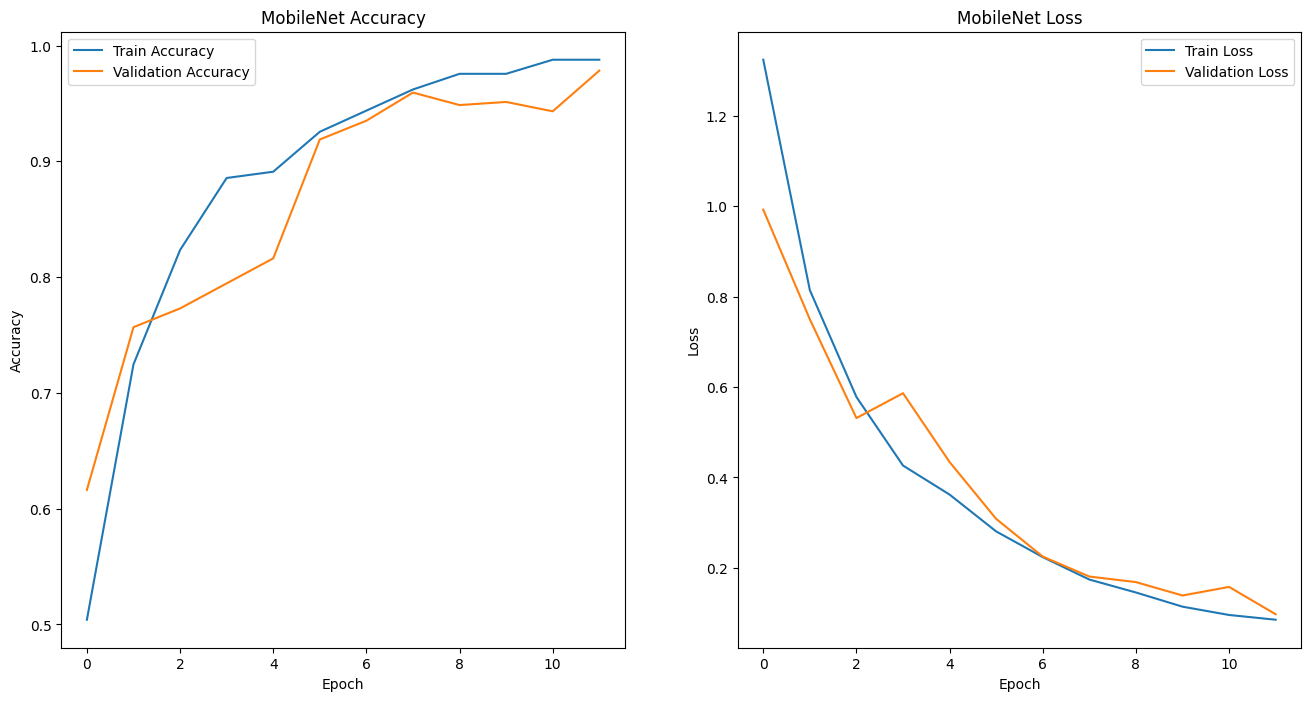

In [35]:
# Plot MobileNet History
plot_training_history(history_mobilenet, 'MobileNet')

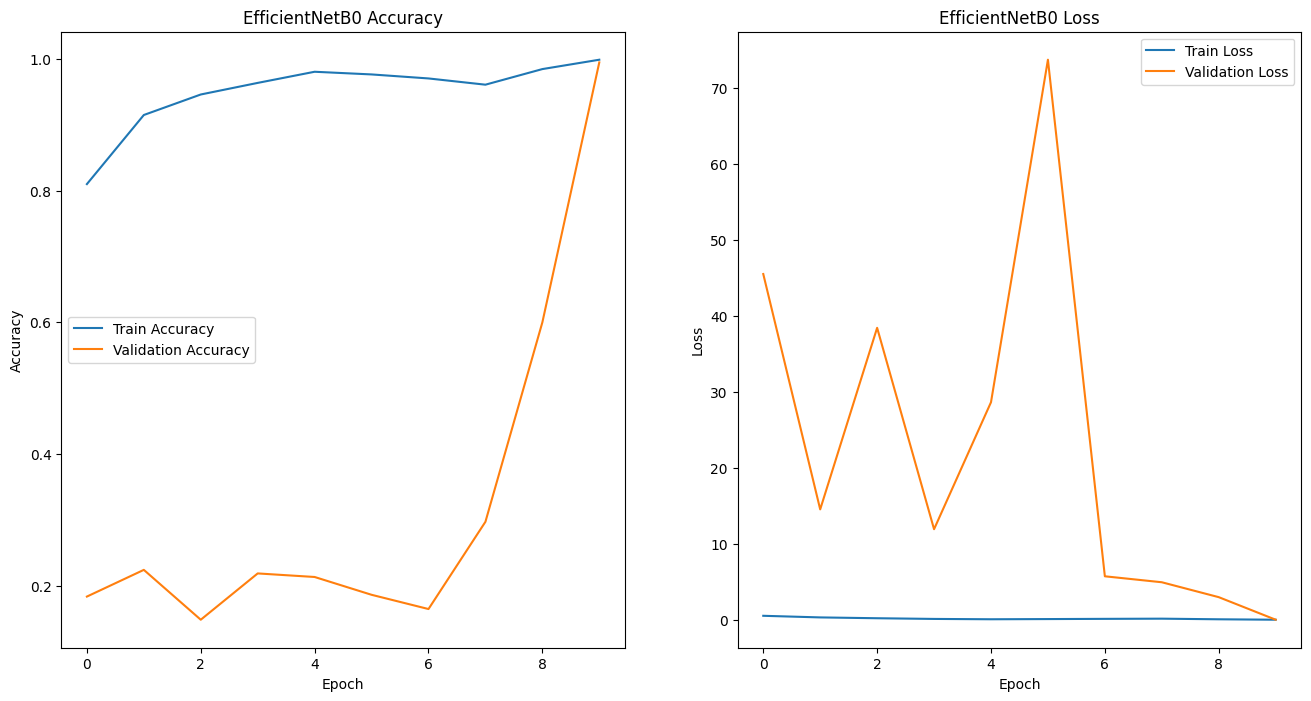

In [36]:
# Plot EfficientNetB0 History
plot_training_history(history_efficientnet, 'EfficientNetB0')

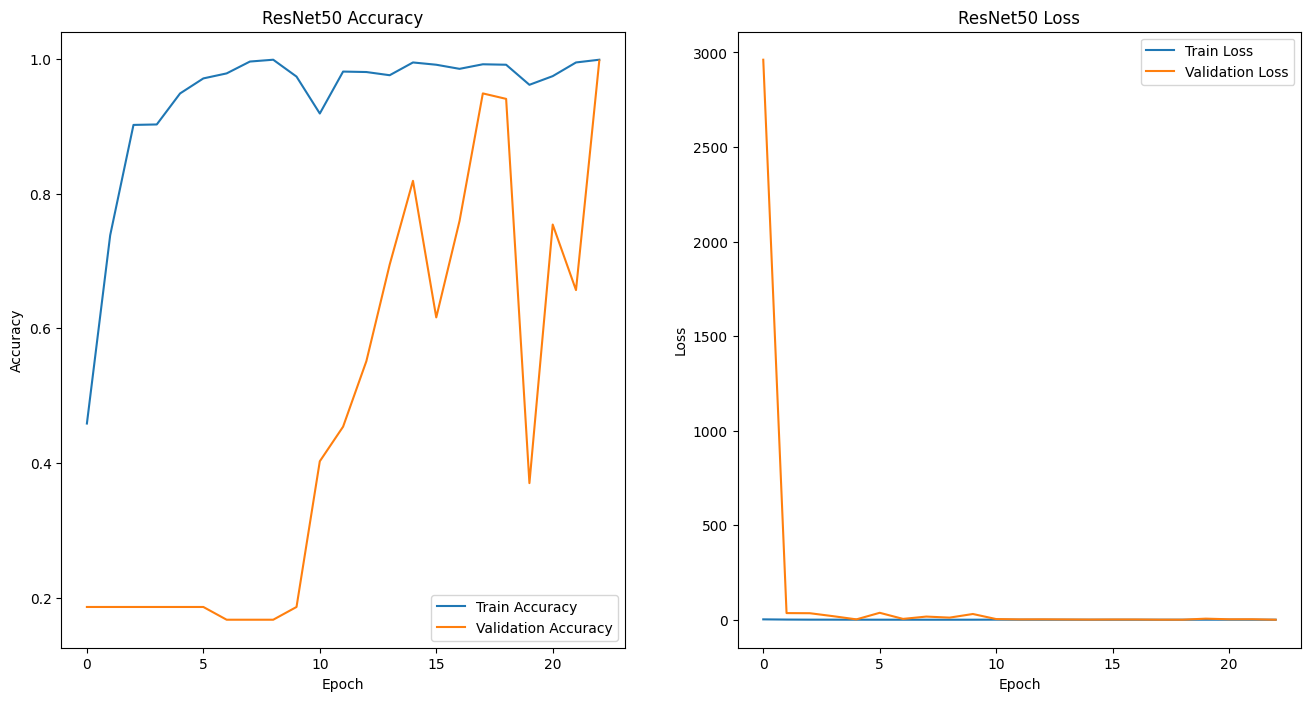

In [37]:
# Plot ResNet50 History
plot_training_history(history_resnet, 'ResNet50')

In [45]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import time
import psutil
import os
import tensorflow as tf

# دالة لتقييم النموذج
def evaluate_model(model, X_test, y_test):
    # حساب الوقت
    start_time = time.time()

    # إجراء التنبؤات
    y_pred = model.predict(X_test)

    # حساب الزمن
    inference_time = time.time() - start_time

    # حساب المقاييس
    if y_test.ndim == 2 and y_test.shape[1] > 1:  # Check if y_test is one-hot encoded
        y_test = np.argmax(y_test, axis=1)  # Convert to multiclass
    f1 = f1_score(y_test, y_pred.argmax(axis=1), average='weighted')
    precision = precision_score(y_test, y_pred.argmax(axis=1), average='weighted')
    recall = recall_score(y_test, y_pred.argmax(axis=1), average='weighted')
    if y_test.ndim == 1:  # Check if y_test is multiclass
        y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=y_pred.shape[1])  # Convert to one-hot
    else:
        y_test_onehot = y_test  # If already one-hot, no conversion needed
    auc = roc_auc_score(y_test_onehot, y_pred, multi_class='ovr')
    # قياس استهلاك الذاكرة
    memory_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # بالميجابايت

    # حساب حجم النموذج
    model_size = model.count_params() * 4 / 1024 / 1024  # بالميجابايت

    # ملاحظة: يمكن التعديل للحصول على استهلاك الطاقة حسب الأجهزة
    power_consumption = None  # يعتمد على الجهاز (ليس من السهل قياسه مباشرة)

    return {
        'inference_time': inference_time,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': auc,
        'memory_usage': memory_usage,
        'model_size': model_size,
        'power_consumption': power_consumption
    }


In [39]:
# تقييم النماذج الأصلية
original_models = {
    'efficientnet_model': efficientnet_model,
    'resnet_model': resnet_model,
    'mobilenet_model': mobilenet_model
}



In [40]:
# تقييم نماذج الطلاب بعد Quantization و Knowledge Distillation
distilled_models = {
    'efficientnet_student_model': efficientnet_student_model,
    'resnet_student_model': resnet_student_model,
    'mobilenet_student_model': mobilenet_student_model
}



In [41]:
# تقييم كل نموذج
results = {}



In [46]:
# تقييم النماذج الأصلية
for model_name, model in original_models.items():
    results[model_name] = evaluate_model(model, X_test, y_test_categorical)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 539ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step


In [47]:

# تقييم نماذج الطلاب بعد Quantization و Knowledge Distillation
for model_name, model in distilled_models.items():
    results[model_name] = evaluate_model(model, X_test, y_test_categorical)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:

# عرض النتائج
import pandas as pd
df_results = pd.DataFrame(results).T
print(df_results)

                            inference_time  f1_score  precision    recall  \
efficientnet_model                0.547061  0.607400   0.729237  0.610811   
resnet_model                     10.462378  0.473186   0.638599  0.489189   
mobilenet_model                   5.344752  0.496085   0.562925  0.502703   
efficientnet_student_model        0.629606  0.048098   0.028079  0.167568   
resnet_student_model              0.615562  0.997297   0.997341  0.997297   
mobilenet_student_model           0.400324  0.122166   0.121017  0.175676   

                             roc_auc  memory_usage  model_size  \
efficientnet_model          0.882889   9267.222656   20.475254   
resnet_model                0.834825   9358.500000   98.007347   
mobilenet_model             0.806933   9435.722656   16.344505   
efficientnet_student_model  0.422435   9493.609375   20.475254   
resnet_student_model        0.999965   9523.882812   98.007347   
mobilenet_student_model     0.480138   9573.460938    9.241966  